In [1]:
import graphlab
import pysal as ps
import random as rdm
from pylab import *
import numpy as np
import pandas as pd
import pysal as ps

This non-commercial license of GraphLab Create for academic use is assigned to chen.zhong@kcl.ac.uk and will expire on June 26, 2019.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1530191767.log


In [2]:
pd.options.display.max_rows = 10
pd.set_option("display.precision", 4)

In [3]:
#cleaning and filter the words
import datetime
import sys
import codecs
import re
import urllib, urllib2
import itertools, collections

import nltk  # Natural Language Processing
#nltk.download('punkt')
#nltk.download('all')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords # list of words
from collections import Counter  # optimized way to do this
import string  # list(string.punctuation) - produces a list of punctuations
import copy
from itertools import product, tee, combinations, chain
from nltk.stem import PorterStemmer
from operator import itemgetter # help with dataframes

from scipy.spatial.distance import cosine

from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle

#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

In [4]:
# Regex from Gagan ************************************************************

emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

# Regex_str is used to GET text from CSV file

regex_str = [
    
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-signs
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)' # other words
]

# These Regex are used to EXCLUDE items from the text AFTER IMPORTING from csv with regex_str

numbers = r'(?:(?:\d+,?)+(?:\.?\d+)?)'
URL = r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+'
html_tag = r'<[^>]+>'
hash_tag = r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)"
at_sign = r'(?:@[\w_]+)'
dash_quote = r"(?:[a-z][a-z'\-_]+[a-z])"
other_word = r'(?:[\w_]+)'
other_stuff = r'(?:\S)' # anything else - NOT USED
start_pound = r"([#?])(\w+)" # Start with #
start_quest_pound = r"(?:^|\s)([#?])(\w+)" # Start with ? or with #
cont_number = r'(\w*\d\w*)' # Words containing numbers

# My REGEX **************************************************************************

#      Remove '[' and ']' brackets

sq_br_f = r'(?:[[\w_]+)' # removes '['
sq_br_b = r'(?:][\w_]+)' # removes ']'

rem_bracket = r'(' + '|'.join([sq_br_f, sq_br_b]) +')'
rem_bracketC = re.compile(rem_bracket, re.VERBOSE)

# Removes all words of 3 characters or less *****************************************************

short_words = r'\W*\b\w{1,3}\b' # Short words of 3 character or less
short_wordsC = re.compile(short_words, re.VERBOSE | re.IGNORECASE)

# REGEX remove all words with \ and / combinations

slash_back =  r'\s*(?:[\w_]*\\(?:[\w_]*\\)*[\w_]*)'
slash_fwd = r'\s*(?:[\w_]*/(?:[\w_]*/)*[\w_]*)'
slash_all = r'\s*(?:[\w_]*[/\\](?:[\w_]*[/\\])*[\w_]*)'

# REGEX numbers, short words and URL only to EXCLUDE +++++++++++++++++++++++++++++++++++++++++++++++++++

num_url_short = r'(' + '|'.join([numbers, URL, short_words + sq_br_f + sq_br_b]) +')'  # Exclude from tweets
comp_num_url_short = re.compile(num_url_short, re.VERBOSE | re.IGNORECASE)

# Master REGEX to INCLUDE from the original tweets ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

list_regex = r'(' + '|'.join(regex_str) + ')'

master_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE) # TAKE from tweets INITIALLY

In [5]:
char_remove = [']', '[', '(', ')', '{', '}'] # characters to be removed

#the other 3character length words will be removed
words_keep = ['old', 'new', 'age', 'lot', 'bag', 'top', 'cat', 'bat', 'sap', 'jda', 'tea', 'dog', 'lie', 'law', 'lab',\
             'mob', 'map', 'car', 'fat', 'sea', 'saw', 'raw', 'rob', 'win', 'can', 'get', 'fan', 'fun', 'big',\
             'use', 'pea', 'pit','pot', 'pat', 'ear', 'eye', 'kit', 'pot', 'pen', 'bud', 'bet', 'god', 'tax', 'won', 'run',\
              'lid', 'log', 'pr', 'pd', 'cop', 'nyc', 'ny', 'la', 'toy', 'war', 'law', 'lax', 'jfk', 'fed', 'cry', 'ceo',\
              'pay', 'pet', 'fan', 'fun', 'usd', 'rio']

emotion_list = [':)', ';)', '(:', '(;', '}', '{','}']


word_garb = ['here', 'there', 'where', 'when', 'would', 'should', 'could','thats', 'youre', 'thanks', 'hasn',\
             'thank', 'https', 'since', 'wanna', 'gonna', 'aint', 'http', 'unto', 'onto', 'into', 'havent',\
             'dont', 'done', 'cant', 'werent', 'https', 'u', 'isnt', 'go', 'theyre', 'each', 'every', 'shes', 'youve', 'youll',\
            'weve', 'theyve']

extra_word_garb = ['today','london','greater']

# Dictionary with Replacement Pairs ******************************************************************************
repl_dict = {'googleele': 'goog', 'lyin': 'lie', 'googles': 'goog', 'aapl':'apple',\
             'msft':'microsoft', 'google': 'goog', 'googl':'goog'}

exclude = list(string.punctuation) + emotion_list + word_garb + extra_word_garb

# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

stemmer=PorterStemmer()
lmtzr = WordNetLemmatizer()

In [6]:
directory = '/Volumes/FREESPACE/workspace/python/twitter_analysis/notebook/output/london2017_q2_msoa.csv'

In [7]:
import sys

df = pd.read_csv(open(directory,'rU'), encoding='utf-8', engine='c', header = 0, 
                 error_bad_lines=False, parse_dates=True)

In [8]:
df.head(3)

,index_right,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,RGN11CD,RGN11NM,USUALRES,HHOLDRES,COMESTRES,POPDEN,HHOLDS,AVHHOLDSZ,text
0,0,E02000001,City of London 001,E09000001,City of London,E12000007,London,7375,7187,188,25.5,4385,1.6,Think like a toddler- when we are at our most ...
1,1,E02000002,Barking and Dagenham 001,E09000002,Barking and Dagenham,E12000007,London,6775,6724,51,31.3,2713,2.5,Just posted a photo @ Moby Dick https://t.co/Z...
2,2,E02000003,Barking and Dagenham 002,E09000002,Barking and Dagenham,E12000007,London,10045,10033,12,46.9,3834,2.6,Working @ Chadwell Heath https://t.co/STy2bMBJ...


In [9]:
# Filters IMPORTED from csv file data

def filterPick(list, filter):
    return [ ( l, m.group(1) ) for l in list for m in (filter(l),) if m]

search_regex = re.compile(list_regex, re.VERBOSE | re.IGNORECASE).search

In [10]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde
print (sys.stdout)

tweet_list_org = df['text'].tolist() 

tweet_list_org = [str(l).encode('ascii','ignore') for l in tweet_list_org]

outlist_init = filterPick(tweet_list_org, search_regex) # It is a tuple: initial list from all tweets

In [11]:
len(outlist_init)

983

In [12]:
# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

# Preparing CLEAN tweets tp keep SEPARATELY from WORDS in TWEETS

tweet_clean_fin = [] # Cleaned Tweets - Final Version

In [13]:
# Convert tuple to a list, then to a string; Remove the characters; Stays as a STRING. Porter Stemmer

# Preparing CLEAN tweets tp keep SEPARATELY from WORDS in TWEETS
count = 0
for tweet in outlist_init:
    count = count +1
    if count%50 == 0:
        print(count)
    tw_clean = []
    tw_clean = [ch for ch in tweet if ch not in char_remove]

    tw_clean = re.sub(URL, "", str(tw_clean))
    tw_clean = re.sub(html_tag, "",str(tw_clean))
    tw_clean = re.sub(hash_tag, "",str(tw_clean))
    tw_clean = re.sub(slash_all,"", str(tw_clean))
    tw_clean = re.sub(cont_number, "",str(tw_clean))
    tw_clean = re.sub(numbers, "",str(tw_clean))
    tw_clean = re.sub(start_pound, "",str(tw_clean))
    tw_clean = re.sub(start_quest_pound, "",str(tw_clean))
    tw_clean = re.sub(at_sign, "",str(tw_clean))
    tw_clean = re.sub("'", "",str(tw_clean))
    tw_clean = re.sub('"', "",str(tw_clean))
    tw_clean = re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', tw_clean) # Removes # and @ in words (lookahead)

    tw_clean = lmtzr.lemmatize(str(tw_clean))
    #tw_clean = stemmer.stem(str(tw_clean))
    
    tw_clean_lst = re.findall(r'\w+', str(tw_clean))
    
    tw_clean_lst = [tw.lower() for tw in tw_clean_lst if tw.lower() not in stopwords.words('english')]
    tw_clean_lst = [word for word in tw_clean_lst if word not in exclude]
    tw_clean_lst = str([word for word in tw_clean_lst if len(word)>3 or word.lower() in words_keep])
    
    tw_clean_lst = re.findall(r'\w+', str(tw_clean_lst))
    #tw_clean_lst = [replace_all(word, repl_dict) for word in tw_clean_lst]
    
    tweet_clean_fin.append(list(tw_clean_lst))

50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [91]:
len(tweet_clean_fin)

983

In [92]:
from __future__ import print_function
from time import time

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

import numpy as np
import pandas as pd

import HTMLParser

#we have to do cleaning, before we go for analysis 
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import string
%matplotlib inline

In [93]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [94]:
import sys
stdi,stdo,stde=sys.stdin,sys.stdout,sys.stderr
reload(sys)
sys.setdefaultencoding('utf8')
sys.stdin,sys.stdout,sys.stderr=stdi,stdo,stde

In [95]:
data_samples = [" ".join(i) for i in tweet_clean_fin]
n_features = 50
n_topics = 10
n_top_words = 15

In [96]:
data_samples[3]

'dagenham united kingdom going discover new dagenham united kingdom beautiful pastormy mother christ celebrates birthday anymore stupid dagenham united kingdom sacha watched get lucky last night excellent film great direction cast rated movie bonds micro rings create extra thickness strolling wedding like dagenham united kingdom much fun little weirdo trying make cheesy puff smile selfies nicholas road dagenham humble dagenham united kingdom makes difference bonds makes huge difference adding extra want calm positive birth experience looking evening hypnobirthing dagenham united kingdom though judemw dagenham united kingdom posted photo dagenham united kingdom daughter sharing birthday ride new bag finally arrived dagenham united kingdom love love love positive feedback hair clients using micro ring sporting heroes posted photo dagenham united kingdom minute rayf run feel schedule evening went explore great hair first dagenham united kingdom begun dagenham united kingdom props amazing 

In [97]:
# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')

Extracting tf features for LDA...


In [98]:
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
(time() - t0)

done in 1.519s.


1.5191547870635986

In [99]:
print("Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (len(data_samples), n_features))
lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=200,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in LDA model:")
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, n_top_words)

#####here we do something to interpret the model

Fitting LDA models with tf features, n_samples=983 and n_features=50...
done in 83.915s.

Topics in LDA model:
Topic #0:
night drinking tonight great new time love good club best happy like come amazing sunday
Topic #1:
street city great new big good morning time work photo posted place love amazing lunch
Topic #2:
station hotel time home drinking good great photo posted best old food amazing new week
Topic #3:
garden happy birthday beautiful lovely great love little new time lunch night best morning week
Topic #4:
house old photo lovely place beautiful time great posted sunday little love morning ready best
Topic #5:
soho theatre street night great new time love photo amazing tonight hotel club house lunch
Topic #6:
new time work like great look love fun good week little ready people weekend summer
Topic #7:
come saturday week place weekend great street best new look summer love old good home
Topic #8:
photo posted good time morning love night great home big new like beautiful amazing

In [100]:
lda

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=200, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)

In [101]:
# Create Document - Topic Matrix
data_vectorized = tf_vectorizer.fit_transform(data_samples)
lda_output = lda.transform(data_vectorized)

In [102]:

# column names
topicnames = ["Topic" + str(i) for i in range(lda.n_topics)]

In [103]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data_samples))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

(array([ 285.,   17.,   25.,  119.,   11.,   13.,  214.,   13.,  216.,   70.]),
 array([ 0. ,  0.9,  1.8,  2.7,  3.6,  4.5,  5.4,  6.3,  7.2,  8.1,  9. ]),
 <a list of 10 Patch objects>)

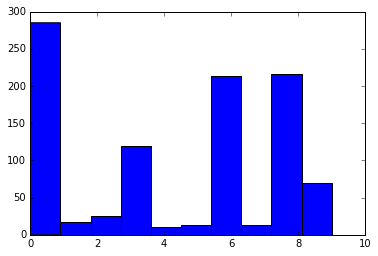

In [104]:
plt.hist(dominant_topic,10)

In [64]:
rs = df[['index_right','NAME','GSS_CODE']]
rs['topics'] = pd.Series(dominant_topic).values

/Users/chenzhong/anaconda2/envs/gl-env/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [66]:
rs.head(10)

,index_right,NAME,GSS_CODE,topics
0,0,Chessington South,E05000405,4
1,1,Tolworth and Hook Rise,E05000414,3
2,2,Berrylands,E05000401,9
3,3,Alexandra,E05000400,9
4,4,Beverley,E05000402,9
5,5,Coombe Hill,E05000406,4
6,6,Chessington North and Hook,E05000404,4
7,7,Surbiton Hill,E05000413,4
8,8,Old Malden,E05000410,5
9,9,St. Mark's,E05000412,9


In [67]:
rs.to_csv('rs_2017_q3.csv')

In [85]:
tf_feature_names

[u'good',
 u'great',
 u'greater',
 u'london',
 u'love',
 u'new',
 u'night',
 u'park',
 u'time',
 u'today']

In [44]:
# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

# Use tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=10,
                                   max_features=n_features,
                                   stop_words='english')
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Fit the NMF model
print("Fitting the NMF model with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (len(data_samples), n_features))
t0 = time()
nmf = NMF(n_components=n_topics, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

print("\nTopics in NMF model:")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)

Extracting tf-idf features for NMF...
done in 1.658s.
Fitting the NMF model with tf-idf features, n_samples=630 and n_features=50...
done in 0.096s.

Topics in NMF model:
Topic #0:
london greater today night good love new city street posted photo time great like best
Topic #1:
great time night love week morning happy good lovely tonight like beautiful work little weekend
Topic #2:
park morning london today beautiful good best sunday time look home house little great posted
Topic #3:
drinking old good great home evening little friday night new today like looking happy saturday
Topic #4:
photo posted lovely beautiful london ready night life look home evening morning love fun happy
Topic #5:
new come great ready good fun like time look love work amazing life saturday home
Topic #6:
station time greater lovely fun big beautiful great tonight good theatre home like look friday
Topic #7:
today happy time garden weekend like birthday look work fun little love life looking saturday
Topic #8:
c

In [24]:
# Delete various elements from the text (LIST OF WORDS)

out_list_fin = []
out_string_temp = ''.join([ch for ch in str(list(outlist_init)) if ch not in char_remove])

out_string_temp = re.sub(URL, "", out_string_temp)
out_string_temp = re.sub(html_tag, "", out_string_temp)
out_string_temp = re.sub(hash_tag, "", out_string_temp)
out_string_temp = re.sub(slash_all,"", str(out_string_temp))
out_string_temp = re.sub(cont_number, "", out_string_temp) 
out_string_temp = re.sub(numbers, "", out_string_temp)
out_string_temp = re.sub(start_pound, "", out_string_temp)
out_string_temp = re.sub(start_quest_pound, "", out_string_temp)
out_string_temp = re.sub(at_sign, "", out_string_temp)
out_string_temp = re.sub("'", "", out_string_temp)
out_string_temp = re.sub('"', "", out_string_temp)
out_string_temp = re.sub(r'(?:^|\s)[@#].*?(?=[,;:.!?]|\s|$)', r'', out_string_temp) # Removes # and @ in words (lookahead)

out_list_w = re.findall(r'\w+', out_string_temp)

out_string_short = str([word.lower() for word in out_list_w if len(word)>3 or word.lower() in words_keep])

out_list_w = re.findall(r'\w+', out_string_short)   

out_list_w = [lmtzr.lemmatize(word) for word in out_list_w]
#out_list_w = [stemmer.stem(word) for word in out_list_w]
out_list_w = [word.lower() for word in out_list_w if word.lower() not in stopwords.words('english')]  # Remove stopwords
out_list_w = str([word.lower() for word in out_list_w if word not in exclude])
out_string_rpl = replace_all(out_list_w, repl_dict) # replace all words from dictionary

KeyboardInterrupt: 

In [ ]:
# Convert "Cleaned" STRING to a LIST

out_list_fin = re.findall(r'\w+', out_string_rpl)

list_len = len(out_list_fin)
word_list = set(out_list_fin) # list of unique words from all tweets - SET
word_list_len = len(word_list)

print "Set = ", word_list_len, "Original Qty = ", list_len
print word_list
print '********************************************************************************************************'
print tweet_clean_fin
print len(tweet_clean_fin)

In [ ]:
# Create a matrix of frequencies for word pairs

words = {v:k for (k, v) in enumerate(word_list)}
keys = words.keys() # List all UNIQUE words in the dictionary from all CLEANED tweets   
l_keys = len(keys) 

matrix_pair = np.zeros([l_keys, l_keys]) # store all combination of keys

for tweet in tweet_clean_fin:
    word_l = []
    
    for word in tweet:
        word_l.append(word)         # List of words from ONE CLEANED tweet
    
    items = set(word_l)  #set of words in from ONE CLEANED tweet
    items = [term for term in items if term in keys] # take only words from a tweet that are in keys
    index = [words[pos] for pos in items] # positions of the words

    for i1 in index: 
        for i2 in index:
            if i1< i2:
                matrix_pair[i1][i2] += 1  #frequency
                
print "Frequency Matrix *********************************************"
print matrix_pair
print "                                                              "

print 'Maximum Frequency', np.max(matrix_pair)
print "                                                             "

idx1, idx2 = nanargmax(matrix_pair)

print "Indexes for a pair with max frequency - ", idx1, idx2
print "Pair of Words with Max Frequency: Word1 - ", words.keys()[idx1], "  Word2 - ", words.keys()[idx2]
print "       

In [ ]:
# Selecting TOP N elements from the Matrix ##########################################################################

n_top = 10

matrix_pairF = matrix_pair.flatten()
idx_f = matrix_pairF.argsort()[-n_top:]
x_idx, y_idx = np.unravel_index(idx_f, matrix_pair.shape)

for x, y, in zip(x_idx, y_idx):
    print("Frequency = ", matrix_pair[x][y], "index1 = ", x, "index2 = ", y, "Word1 - ", words.keys()[x], "  Word2 - ", words.keys()[y])
    
    
# Create document-term-matrix

columns = word_list
ncols = word_list_len + 1

term_doc = pd.DataFrame(columns = columns)
term_doc.insert(0, "Tweet", " ")
term_doc["Tweet"] = tweetDF["Tweet"]
term_doc.fillna(0, inplace=True)

i_row = 0
for line in tweet_clean_fin:
    
    for word in line:

        for col in xrange(1, ncols-1):
            if word == term_doc.columns[col]: term_doc.iloc[i_row, col] += 1

    i_row += 1

In [ ]:
# DataFrame for Statistics with Totals by Row and by Column
    
statDF = copy.deepcopy(term_doc)
columns_cl = ["Tweet", "Sim"]
tweet_sim = pd.DataFrame(columns = columns_cl)
tweet_sim = tweetDF["Tweet"]
tweet_sim.fillna(0.0, inplace=True)

# Sum Rows by Columns
row_sum = statDF.sum(axis=1)
statDF["Total"] = row_sum
print 'Row Max Value = ', row_sum.max()
print "Max Value DF = ", statDF["Total"].max(axis=0)

# Sum Columns by Row:
col_list = list(statDF)
col_list.remove('Tweet')

rsum = {col: statDF[col].sum() for col in col_list}
# Turn the sums into a DataFrame with one row with an index of 'Total':
sum_df = pd.DataFrame(rsum, index=["Total"])
# Now append the row:
statDF = statDF.append(sum_df)

In [ ]:
# Calculate Similarity of Unique Words
tup_word = [] # need to pull column headers and rows af words
sim_word = np.zeros((ncols, ncols))

for i in xrange(ncols-1):
    
    v1 = [0.0]*ncols
    v1 = term_doc.iloc[:, i+1]
    
    for k in xrange(ncols-1):
        
        v2 = [0.0]*ncols 
        if i >= k: pass
        else:
            v2 = term_doc.iloc[:, k+1]
            similar = cosine_sim(v1, v2)
            tup_w = (similar, list(columns)[i], list(columns)[k])

            tup_word.append(tup_w)
            sim_word[i,k] = similar
            sim_word[k,i] = similar
    
    sim_word[i,i] = 1.0

sim_word[ncols-1,ncols-1] = 1.0

print 'Similarity for Words: Words = ', word_list_len
print sim_word

# SIMILARITY for TWEETS
tu_tweet = []
sim_tweet = np.zeros((num_tweets, num_tweets))

for i in xrange(num_tweets):
    
    v1 = [0.0]*num_tweets
    v1 = term_doc.iloc[i, 1:]
    
    for k in xrange(num_tweets):
        
        v2 = [0.0]*num_tweets
        if i >= k: pass
        else:
            v2 = term_doc.iloc[k, 1:]
            similar = cosine_sim(v1, v2)
            tup_twe = (similar, term_doc['Tweet'][i], term_doc['Tweet'][k])
            tu_tweet.append(tup_twe)
            
            sim_tweet[i, k] = similar
            sim_tweet[k, i] = similar
    sim_tweet[i,i] = 1.0

print '                                                                                         '
print "Similarity for Tweets: Tweets = ", num_tweets
print sim_tweet

statDF.tail()

# Determine Top N TWEETS / WORDS

K_neighbor(n_top, tweetDF['Tweet'][498], tu_tweet)  #Top tweets for a given tweet

K_neighbor(n_top, 'accelerator', tup_word)  #Top words for a given word



def tweet_prep(df):
    
    tweet_list = df['Tweet'].tolist()
    tweet_list_clean = df['Clean_Tweet'].tolist()
    word_list_cl = [[word for word in str(line).split()] for line in tweet_list_clean]
    word_list_tot = list(chain.from_iterable(word_list_cl))
    
    set_word = set(word_list_tot) # from clean tweets
    
    return Pair_words(set_word, tweet_list_clean, n_top)

print "Top ", n_top, " pairs of words"

most_comm = Pair_words(word_list, tweet_clean_fin, n_top)

print most_comm

In [ ]:
# Define Top K Neighbours to the WORD or TWEET ***************************************************************************
def K_neighbor(k, term, list_t):
    
    # list_t - a list of tuples
    # term - value of criteria (tweet or word)
    
    neighbor = []
    neighbor = [item for item in list_t if term in item] 
    neighbor.append(item) 
    
    neighbor.sort(key = itemgetter(0), reverse=True)
      
    print ('Top %d' %k, ' elements for %s' %term)
    print ('**********************************************')
        
    for i in xrange(k):
        print (neighbor[i])
    
    return neighbor[:k]

In [86]:
#from tweepy import Stream

encodingTot = sys.stdout.encoding or 'utf-8'

# Similarity Measure *******************************************************************************************
def cosine_sim(v1, v2):
        
    rho = round(1.0 - cosine(v1, v2), 3)
    rho = rho if(not np.isnan(rho)) else 0.0
    return rho

# Words Replacement ***************************************************************************************
def replace_all(text, dic):
    for i, j in dic.iteritems():
        text = text.replace(i, j)
    return text

# Function to find element with Maximum Frequency in TDM  *******************************************************************
def nanargmax(a):
    idx = np.argmax(a, axis=None)
    multi_idx = np.unravel_index(idx, a.shape)
    if np.isnan(a[multi_idx]):
        nan_count = np.sum(np.isnan(a))

        idx = np.argpartition(a, -nan_count-1, axis=None)[-nan_count-1]
        multi_idx = np.unravel_index(idx, a.shape)
    return multi_idx



# Determine Pair of Words Counter method ******************************************************************************
def Pair_words(word_list, tweet_clean_fin, n_top):

    pairs = list(itertools.combinations(word_list, 2)) # order does not matter

    #pairs = set(map(tuple, map(sorted, _pairs)))
    pairs = set(pairs)
    c = collections.Counter()

    for tweet in tweet_clean_fin:
        for pair in pairs:
            if pair[0] == pair[1]: 
                pass
            elif pair[0] in tweet and pair[1] in tweet:
                #c.update({pair: 1})
                c[pair] +=1
 
    return c.most_common(n_top)

In [87]:
# BIC score function ********************************************************************************

from sklearn import cluster
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler

def compute_bic(kmeans,X):
    """
    Computes the BIC metric for given clusters

    Parameters:
    -----------------------------------------
    kmeans:  List of clustering object from scikit learn

    X     :  multidimension np array of data points

    """
    # assign centers and labels
    centers = [kmeans.cluster_centers_]
    labels  = kmeans.labels_
    #number of clusters
    m = kmeans.n_clusters
    # size of the clusters
    n = np.bincount(labels)
    #size of data set
    N, d = X.shape

    #compute variance for all clusters beforehand
    cl_var =  (1.0 / (N - m) / d) * sum([sum(distance.cdist(X[np.where(labels == i)], [centers[0][i]], 'euclidean')**2) for i in range(m)])
    const_term = 0.5 * m * np.log(N) * (d+1)

    BIC = np.sum([n[i] * np.log(n[i]) -
               n[i] * np.log(N) -
             ((n[i] * d) / 2) * np.log(2*np.pi*cl_var) -
             ((n[i] - 1) * d/ 2) for i in range(m)]) - const_term

    return(BIC)